# Feature engineering around pressure differences between different locations
- Only QNH pressures were considered  for further work
- QNH are pressure measurements adjusted to corresponding pressures at sea level
- Determine correlation between features

In [1]:
# Python libs
import numpy as np
import pandas as pd
from os.path import isfile, join
import os
import re

# Custom scripts
import sys
sys.path.append('../04_scripts')
import constants as const
import data_handler as dh
import data_processor as dp
import xgb_handler as xh
import plot_handler as ph
import feature_handler as fh

In [2]:
pd.options.display.float_format = '{:,.3f}'.format # Limit output to 3 decimal places.
pd.set_option('display.max_columns', None)

In [3]:
df = dh.load_df_from_csv('master_weather_data_interpolated_only.csv.zip')
df.head()

datetime  KLO_Wind_dir_interp  KLO_Wind_speed_interp  \
0  2014-01-01 00:00:00              138.000                  3.900   
1  2014-01-01 00:10:00              149.000                  3.300   
2  2014-01-01 00:20:00              145.000                  3.100   
3  2014-01-01 00:30:00              127.000                  3.700   
4  2014-01-01 00:40:00              131.000                  4.100   

   KLO_Wind_max_interp  KLO_QFF_interp  KLO_QNH_interp  KLO_QFE_interp  \
0                5.600       1,019.400       1,016.600         966.100   
1                5.700       1,019.500       1,016.700         966.200   
2                4.400       1,019.500       1,016.700         966.200   
3                4.600       1,019.500       1,016.700         966.200   
4                5.000       1,019.300       1,016.600         966.100   

   KLO_Air_temp_interp  KLO_Hum_interp  REH_Wind_dir_interp  \
0               -3.000          96.100              104.000   
1               -3.000          95.200               93.000   
2               -3.000          94.400               69.000   
3               -2.900          91.700               79.000   
4               -2.800          90.800               98.000   

   REH_Wind_speed_interp  REH_Wind_max_interp  REH_QFF_interp  REH_QNH_interp  \
0                  0.900                1.500       1,019.400       1,016.600   
1                  1.300                2.300       1,019.300       1,016.600   
2                  1.300                2.000       1,019.400       1,016.600   
3                  1.400                2.300       1,019.400       1,016.600   
4                  1.200                2.000       1,019.400       1,016.600   

   REH_QFE_interp  REH_Air_temp_interp  REH_Hum_interp  SMA_Wind_dir_interp  \
0         964.100               -2.700          98.100              201.000   
1         964.100               -2.400          98.200              202.000   
2         964.100               -2.600         100.000              193.000   
3         964.100               -2.600          99.000              200.000   
4         964.100               -2.600          98.600              216.000   

   SMA_Wind_speed_interp  SMA_Wind_max_interp  SMA_QFF_interp  SMA_QNH_interp  \
0                  2.400                4.200       1,018.400       1,016.000   
1                  2.300                5.100       1,018.500       1,016.000   
2                  3.100                4.600       1,018.400       1,016.000   
3                  2.600                4.500       1,018.200       1,016.000   
4                  1.700                4.200       1,018.600       1,016.000   

   SMA_QFE_interp  SMA_Air_temp_interp  SMA_Hum_interp  TAE_Wind_dir_interp  \
0         950.700                1.000          67.400               68.000   
1         950.700                0.700          70.600              358.000   
2         950.700                1.200          65.800              344.000   
3         950.700                2.000          60.100              229.000   
4         950.700                0.400          72.200              227.000   

   TAE_Wind_speed_interp  TAE_Wind_max_interp  TAE_QFF_interp  TAE_QNH_interp  \
0                  0.800                2.200       1,019.100       1,015.600   
1                  1.400                2.600       1,018.800       1,015.600   
2                  1.400                2.800       1,018.200       1,015.600   
3                  2.500                6.500       1,017.200       1,015.300   
4                  3.700                7.900       1,017.000       1,015.200   

   TAE_QFE_interp  TAE_Air_temp_interp  TAE_Hum_interp  WAE_Wind_dir_interp  \
0         952.300               -3.800          89.500              152.000   
1         952.300               -2.600          84.300              143.000   
2         952.300               -0.200          67.900              127.000   
3         952.100                2.800    

In [4]:
df.isna().sum()

datetime                 0
KLO_Wind_dir_interp      0
KLO_Wind_speed_interp    0
KLO_Wind_max_interp      0
KLO_QFF_interp           0
KLO_QNH_interp           0
KLO_QFE_interp           0
KLO_Air_temp_interp      0
KLO_Hum_interp           0
REH_Wind_dir_interp      0
REH_Wind_speed_interp    0
REH_Wind_max_interp      0
REH_QFF_interp           0
REH_QNH_interp           0
REH_QFE_interp           0
REH_Air_temp_interp      0
REH_Hum_interp           0
SMA_Wind_dir_interp      0
SMA_Wind_speed_interp    0
SMA_Wind_max_interp      0
SMA_QFF_interp           0
SMA_QNH_interp           0
SMA_QFE_interp           0
SMA_Air_temp_interp      0
SMA_Hum_interp           0
TAE_Wind_dir_interp      0
TAE_Wind_speed_interp    0
TAE_Wind_max_interp      0
TAE_QFF_interp           0
TAE_QNH_interp           0
                        ..
PUY_Wind_max_interp      0
PUY_QFF_interp           0
PUY_QNH_interp           0
PUY_QFE_interp           0
PUY_Air_temp_interp      0
PUY_Hum_interp           0
S

## Drop '_interp' suffix from column name

In [5]:
cols_to_rename = [c for c in df.columns if re.search('^[A-Z]{3}_', c)]
new_col_names = dict()
for c in cols_to_rename:
    new_col_names[c] = c.replace('_interp', '')
    
df = df.rename(columns=new_col_names)
df.head()

datetime  KLO_Wind_dir  KLO_Wind_speed  KLO_Wind_max   KLO_QFF  \
0  2014-01-01 00:00:00       138.000           3.900         5.600 1,019.400   
1  2014-01-01 00:10:00       149.000           3.300         5.700 1,019.500   
2  2014-01-01 00:20:00       145.000           3.100         4.400 1,019.500   
3  2014-01-01 00:30:00       127.000           3.700         4.600 1,019.500   
4  2014-01-01 00:40:00       131.000           4.100         5.000 1,019.300   

    KLO_QNH  KLO_QFE  KLO_Air_temp  KLO_Hum  REH_Wind_dir  REH_Wind_speed  \
0 1,016.600  966.100        -3.000   96.100       104.000           0.900   
1 1,016.700  966.200        -3.000   95.200        93.000           1.300   
2 1,016.700  966.200        -3.000   94.400        69.000           1.300   
3 1,016.700  966.200        -2.900   91.700        79.000           1.400   
4 1,016.600  966.100        -2.800   90.800        98.000           1.200   

   REH_Wind_max   REH_QFF   REH_QNH  REH_QFE  REH_Air_temp  REH_Hum  \
0         1.500 1,019.400 1,016.600  964.100        -2.700   98.100   
1         2.300 1,019.300 1,016.600  964.100        -2.400   98.200   
2         2.000 1,019.400 1,016.600  964.100        -2.600  100.000   
3         2.300 1,019.400 1,016.600  964.100        -2.600   99.000   
4         2.000 1,019.400 1,016.600  964.100        -2.600   98.600   

   SMA_Wind_dir  SMA_Wind_speed  SMA_Wind_max   SMA_QFF   SMA_QNH  SMA_QFE  \
0       201.000           2.400         4.200 1,018.400 1,016.000  950.700   
1       202.000           2.300         5.100 1,018.500 1,016.000  950.700   
2       193.000           3.100         4.600 1,018.400 1,016.000  950.700   
3       200.000           2.600         4.500 1,018.200 1,016.000  950.700   
4       216.000           1.700         4.200 1,018.600 1,016.000  950.700   

   SMA_Air_temp  SMA_Hum  TAE_Wind_dir  TAE_Wind_speed  TAE_Wind_max  \
0         1.000   67.400        68.000           0.800         2.200   
1         0.700   70.600       358.000           1.400         2.600   
2         1.200   65.800       344.000           1.400         2.800   
3         2.000   60.100       229.000           2.500         6.500   
4         0.400   72.200       227.000           3.700         7.900   

    TAE_QFF   TAE_QNH  TAE_QFE  TAE_Air_temp  TAE_Hum  WAE_Wind_dir  \
0 1,019.100 1,015.600  952.300        -3.800   89.500       152.000   
1 1,018.800 1,015.600  952.300        -2.600   84.300       143.000   
2 1,018.200 1,015.600  952.300        -0.200   67.900       127.000   
3 1,017.200 1,015.300  952.100         2.800   56.400       143.000   
4 1,017.000 1,015.200  952.000         3.300   55.400       142.000   

   WAE_Wind_speed  WAE_Wind_max   WAE_QFF   WAE_QNH  WAE_QFE  WAE_Air_temp  \
0           1.900         3.800 1,019.600 1,016.900  959.600        -1.300   
1           2.000         2.900 1,019.500 1,016.900  959.600        -0.800   
2           1.800         3.300 1,019.500 1,017.000  959.700        -0.300   
3           2.400         3.900 1,019.500 1,017.000  959.700        -0.400   
4           2.400         3.900 1,019.400 1,016.900  959.600        -0.200   

   WAE_Hum  BIZ_Wind_dir  BIZ_Wind_speed  BIZ_Wind_max   BIZ_QFF   BIZ_QNH  \
0   82.600       283.000           0.700         1.300 1,020.300 1,016.800   
1   84.300       265.000           0.800         1.500 1,020.200 1,016.700   
2   88.400       238.000           0.700         1.100 1,020.100 1,016.600   
3   88.400       271.000           0.800         1.600 1,020.000 1,016.500   
4   85.900       270.000           0.700         1.200 1,019.800 1,016.400   

   BIZ_QFE  BIZ_Air_temp  BIZ_Hum  BUS_Wind_dir  BUS_Wind_speed  BUS_Wind_max  \
0  961.600        -5.200  100.000       303.000           0.900         1.600   
1  961.500        -5.200  100.000       302.000           1.000         1.700   
2  961.400        -5.300  100.000       261.000           0.500         1.000   
3  961.300        -5.100  100.000       292.000     

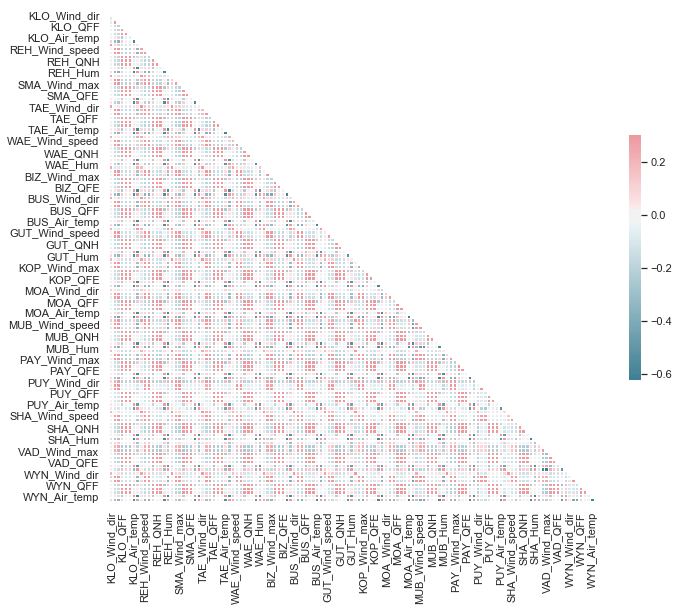

In [5]:
ph.plot_correlation_map(df)

In [9]:
df.isna().sum()[df.isna().sum() > 0]

Series([], dtype: int64)

## Store / load a clean basic dataset

In [ ]:
dh.store_df_as_csv_compressed(df, 'master_model_features.csv.zip')

In [3]:
df_master = dh.load_df_from_csv('master_model_features.csv.zip')
df_master.head()

datetime  KLO_Wind_dir  KLO_Wind_speed  KLO_Wind_max   KLO_QFF  \
0  2014-01-01 00:00:00       138.000           3.900         5.600 1,019.400   
1  2014-01-01 00:10:00       149.000           3.300         5.700 1,019.500   
2  2014-01-01 00:20:00       145.000           3.100         4.400 1,019.500   
3  2014-01-01 00:30:00       127.000           3.700         4.600 1,019.500   
4  2014-01-01 00:40:00       131.000           4.100         5.000 1,019.300   

    KLO_QNH  KLO_QFE  KLO_Air_temp  KLO_Hum  REH_Wind_dir  REH_Wind_speed  \
0 1,016.600  966.100        -3.000   96.100       104.000           0.900   
1 1,016.700  966.200        -3.000   95.200        93.000           1.300   
2 1,016.700  966.200        -3.000   94.400        69.000           1.300   
3 1,016.700  966.200        -2.900   91.700        79.000           1.400   
4 1,016.600  966.100        -2.800   90.800        98.000           1.200   

   REH_Wind_max   REH_QFF   REH_QNH  REH_QFE  REH_Air_temp  REH_Hum  \
0         1.500 1,019.400 1,016.600  964.100        -2.700   98.100   
1         2.300 1,019.300 1,016.600  964.100        -2.400   98.200   
2         2.000 1,019.400 1,016.600  964.100        -2.600  100.000   
3         2.300 1,019.400 1,016.600  964.100        -2.600   99.000   
4         2.000 1,019.400 1,016.600  964.100        -2.600   98.600   

   SMA_Wind_dir  SMA_Wind_speed  SMA_Wind_max   SMA_QFF   SMA_QNH  SMA_QFE  \
0       201.000           2.400         4.200 1,018.400 1,016.000  950.700   
1       202.000           2.300         5.100 1,018.500 1,016.000  950.700   
2       193.000           3.100         4.600 1,018.400 1,016.000  950.700   
3       200.000           2.600         4.500 1,018.200 1,016.000  950.700   
4       216.000           1.700         4.200 1,018.600 1,016.000  950.700   

   SMA_Air_temp  SMA_Hum  TAE_Wind_dir  TAE_Wind_speed  TAE_Wind_max  \
0         1.000   67.400        68.000           0.800         2.200   
1         0.700   70.600       358.000           1.400         2.600   
2         1.200   65.800       344.000           1.400         2.800   
3         2.000   60.100       229.000           2.500         6.500   
4         0.400   72.200       227.000           3.700         7.900   

    TAE_QFF   TAE_QNH  TAE_QFE  TAE_Air_temp  TAE_Hum  WAE_Wind_dir  \
0 1,019.100 1,015.600  952.300        -3.800   89.500       152.000   
1 1,018.800 1,015.600  952.300        -2.600   84.300       143.000   
2 1,018.200 1,015.600  952.300        -0.200   67.900       127.000   
3 1,017.200 1,015.300  952.100         2.800   56.400       143.000   
4 1,017.000 1,015.200  952.000         3.300   55.400       142.000   

   WAE_Wind_speed  WAE_Wind_max   WAE_QFF   WAE_QNH  WAE_QFE  WAE_Air_temp  \
0           1.900         3.800 1,019.600 1,016.900  959.600        -1.300   
1           2.000         2.900 1,019.500 1,016.900  959.600        -0.800   
2           1.800         3.300 1,019.500 1,017.000  959.700        -0.300   
3           2.400         3.900 1,019.500 1,017.000  959.700        -0.400   
4           2.400         3.900 1,019.400 1,016.900  959.600        -0.200   

   WAE_Hum  BIZ_Wind_dir  BIZ_Wind_speed  BIZ_Wind_max   BIZ_QFF   BIZ_QNH  \
0   82.600       283.000           0.700         1.300 1,020.300 1,016.800   
1   84.300       265.000           0.800         1.500 1,020.200 1,016.700   
2   88.400       238.000           0.700         1.100 1,020.100 1,016.600   
3   88.400       271.000           0.800         1.600 1,020.000 1,016.500   
4   85.900       270.000           0.700         1.200 1,019.800 1,016.400   

   BIZ_QFE  BIZ_Air_temp  BIZ_Hum  BUS_Wind_dir  BUS_Wind_speed  BUS_Wind_max  \
0  961.600        -5.200  100.000       303.000           0.900         1.600   
1  961.500        -5.200  100.000       302.000           1.000         1.700   
2  961.400        -5.300  100.000       261.000           0.500         1.000   
3  961.300        -5.100  100.000       292.000     

## Create a dataset with all generated features
### The master will be kept for visualizing correlations of the added features

In [5]:
df_all_features = df_master.copy()

## Collect all stations and combinations of stations

In [5]:
stations = fh.get_stations(df_master)
stations

array(['BIZ', 'BUS', 'GUT', 'KLO', 'KOP', 'MOA', 'MUB', 'PAY', 'PUY',
       'REH', 'SHA', 'SMA', 'TAE', 'VAD', 'WAE', 'WYN'], dtype='<U3')

In [6]:
combinations = fh.get_station_combinations(df_master)
print(len(combinations))
combinations

KLO
KLO
KLO
KLO
KLO
KLO
KLO
KLO
REH
REH
REH
REH
REH
REH
REH
REH
SMA
SMA
SMA
SMA
SMA
SMA
SMA
SMA
TAE
TAE
TAE
TAE
TAE
TAE
TAE
TAE
WAE
WAE
WAE
WAE
WAE
WAE
WAE
WAE
BIZ
BIZ
BIZ
BIZ
BIZ
BIZ
BIZ
BIZ
BUS
BUS
BUS
BUS
BUS
BUS
BUS
BUS
GUT
GUT
GUT
GUT
GUT
GUT
GUT
GUT
KOP
KOP
KOP
KOP
KOP
KOP
KOP
KOP
MOA
MOA
MOA
MOA
MOA
MOA
MOA
MOA
MUB
MUB
MUB
MUB
MUB
MUB
MUB
MUB
PAY
PAY
PAY
PAY
PAY
PAY
PAY
PAY
PUY
PUY
PUY
PUY
PUY
PUY
PUY
PUY
SHA
SHA
SHA
SHA
SHA
SHA
SHA
SHA
VAD
VAD
VAD
VAD
VAD
VAD
VAD
VAD
WYN
WYN
WYN
WYN
WYN
WYN
WYN
WYN
120


[('BIZ', 'BUS'),
 ('BIZ', 'GUT'),
 ('BIZ', 'KLO'),
 ('BIZ', 'KOP'),
 ('BIZ', 'MOA'),
 ('BIZ', 'MUB'),
 ('BIZ', 'PAY'),
 ('BIZ', 'PUY'),
 ('BIZ', 'REH'),
 ('BIZ', 'SHA'),
 ('BIZ', 'SMA'),
 ('BIZ', 'TAE'),
 ('BIZ', 'VAD'),
 ('BIZ', 'WAE'),
 ('BIZ', 'WYN'),
 ('BUS', 'GUT'),
 ('BUS', 'KLO'),
 ('BUS', 'KOP'),
 ('BUS', 'MOA'),
 ('BUS', 'MUB'),
 ('BUS', 'PAY'),
 ('BUS', 'PUY'),
 ('BUS', 'REH'),
 ('BUS', 'SHA'),
 ('BUS', 'SMA'),
 ('BUS', 'TAE'),
 ('BUS', 'VAD'),
 ('BUS', 'WAE'),
 ('BUS', 'WYN'),
 ('GUT', 'KLO'),
 ('GUT', 'KOP'),
 ('GUT', 'MOA'),
 ('GUT', 'MUB'),
 ('GUT', 'PAY'),
 ('GUT', 'PUY'),
 ('GUT', 'REH'),
 ('GUT', 'SHA'),
 ('GUT', 'SMA'),
 ('GUT', 'TAE'),
 ('GUT', 'VAD'),
 ('GUT', 'WAE'),
 ('GUT', 'WYN'),
 ('KLO', 'KOP'),
 ('KLO', 'MOA'),
 ('KLO', 'MUB'),
 ('KLO', 'PAY'),
 ('KLO', 'PUY'),
 ('KLO', 'REH'),
 ('KLO', 'SHA'),
 ('KLO', 'SMA'),
 ('KLO', 'TAE'),
 ('KLO', 'VAD'),
 ('KLO', 'WAE'),
 ('KLO', 'WYN'),
 ('KOP', 'MOA'),
 ('KOP', 'MUB'),
 ('KOP', 'PAY'),
 ('KOP', 'PUY'),
 ('KOP', 'REH'

In [8]:
df_all_features = fh.calc_feature_diff_between_stations(df_all_features, 'QNH', combinations)
print(df_all_features.shape)
df_all_features.head()

(262801, 249)


datetime  KLO_Wind_dir  KLO_Wind_speed  KLO_Wind_max   KLO_QFF  \
0  2014-01-01 00:00:00       138.000           3.900         5.600 1,019.400   
1  2014-01-01 00:10:00       149.000           3.300         5.700 1,019.500   
2  2014-01-01 00:20:00       145.000           3.100         4.400 1,019.500   
3  2014-01-01 00:30:00       127.000           3.700         4.600 1,019.500   
4  2014-01-01 00:40:00       131.000           4.100         5.000 1,019.300   

    KLO_QNH  KLO_QFE  KLO_Air_temp  KLO_Hum  REH_Wind_dir  REH_Wind_speed  \
0 1,016.600  966.100        -3.000   96.100       104.000           0.900   
1 1,016.700  966.200        -3.000   95.200        93.000           1.300   
2 1,016.700  966.200        -3.000   94.400        69.000           1.300   
3 1,016.700  966.200        -2.900   91.700        79.000           1.400   
4 1,016.600  966.100        -2.800   90.800        98.000           1.200   

   REH_Wind_max   REH_QFF   REH_QNH  REH_QFE  REH_Air_temp  REH_Hum  \
0         1.500 1,019.400 1,016.600  964.100        -2.700   98.100   
1         2.300 1,019.300 1,016.600  964.100        -2.400   98.200   
2         2.000 1,019.400 1,016.600  964.100        -2.600  100.000   
3         2.300 1,019.400 1,016.600  964.100        -2.600   99.000   
4         2.000 1,019.400 1,016.600  964.100        -2.600   98.600   

   SMA_Wind_dir  SMA_Wind_speed  SMA_Wind_max   SMA_QFF   SMA_QNH  SMA_QFE  \
0       201.000           2.400         4.200 1,018.400 1,016.000  950.700   
1       202.000           2.300         5.100 1,018.500 1,016.000  950.700   
2       193.000           3.100         4.600 1,018.400 1,016.000  950.700   
3       200.000           2.600         4.500 1,018.200 1,016.000  950.700   
4       216.000           1.700         4.200 1,018.600 1,016.000  950.700   

   SMA_Air_temp  SMA_Hum  TAE_Wind_dir  TAE_Wind_speed  TAE_Wind_max  \
0         1.000   67.400        68.000           0.800         2.200   
1         0.700   70.600       358.000           1.400         2.600   
2         1.200   65.800       344.000           1.400         2.800   
3         2.000   60.100       229.000           2.500         6.500   
4         0.400   72.200       227.000           3.700         7.900   

    TAE_QFF   TAE_QNH  TAE_QFE  TAE_Air_temp  TAE_Hum  WAE_Wind_dir  \
0 1,019.100 1,015.600  952.300        -3.800   89.500       152.000   
1 1,018.800 1,015.600  952.300        -2.600   84.300       143.000   
2 1,018.200 1,015.600  952.300        -0.200   67.900       127.000   
3 1,017.200 1,015.300  952.100         2.800   56.400       143.000   
4 1,017.000 1,015.200  952.000         3.300   55.400       142.000   

   WAE_Wind_speed  WAE_Wind_max   WAE_QFF   WAE_QNH  WAE_QFE  WAE_Air_temp  \
0           1.900         3.800 1,019.600 1,016.900  959.600        -1.300   
1           2.000         2.900 1,019.500 1,016.900  959.600        -0.800   
2           1.800         3.300 1,019.500 1,017.000  959.700        -0.300   
3           2.400         3.900 1,019.500 1,017.000  959.700        -0.400   
4           2.400         3.900 1,019.400 1,016.900  959.600        -0.200   

   WAE_Hum  BIZ_Wind_dir  BIZ_Wind_speed  BIZ_Wind_max   BIZ_QFF   BIZ_QNH  \
0   82.600       283.000           0.700         1.300 1,020.300 1,016.800   
1   84.300       265.000           0.800         1.500 1,020.200 1,016.700   
2   88.400       238.000           0.700         1.100 1,020.100 1,016.600   
3   88.400       271.000           0.800         1.600 1,020.000 1,016.500   
4   85.900       270.000           0.700         1.200 1,019.800 1,016.400   

   BIZ_QFE  BIZ_Air_temp  BIZ_Hum  BUS_Wind_dir  BUS_Wind_speed  BUS_Wind_max  \
0  961.600        -5.200  100.000       303.000           0.900         1.600   
1  961.500        -5.200  100.000       302.000           1.000         1.700   
2  961.400        -5.300  100.000       261.000           0.500         1.000   
3  961.300        -5.100  100.000       292.000     

In [9]:
print(df_all_features.shape)
dh.store_df_as_csv_compressed(df_all_features, 'model_data_QNH_features.csv.zip')

(262801, 249)


In [3]:
df = dh.load_df_from_csv('model_data_QNH_features.csv.zip')
df.head()

datetime  KLO_Wind_dir  KLO_Wind_speed  KLO_Wind_max   KLO_QFF  \
0  2014-01-01 00:00:00       138.000           3.900         5.600 1,019.400   
1  2014-01-01 00:10:00       149.000           3.300         5.700 1,019.500   
2  2014-01-01 00:20:00       145.000           3.100         4.400 1,019.500   
3  2014-01-01 00:30:00       127.000           3.700         4.600 1,019.500   
4  2014-01-01 00:40:00       131.000           4.100         5.000 1,019.300   

    KLO_QNH  KLO_QFE  KLO_Air_temp  KLO_Hum  REH_Wind_dir  REH_Wind_speed  \
0 1,016.600  966.100        -3.000   96.100       104.000           0.900   
1 1,016.700  966.200        -3.000   95.200        93.000           1.300   
2 1,016.700  966.200        -3.000   94.400        69.000           1.300   
3 1,016.700  966.200        -2.900   91.700        79.000           1.400   
4 1,016.600  966.100        -2.800   90.800        98.000           1.200   

   REH_Wind_max   REH_QFF   REH_QNH  REH_QFE  REH_Air_temp  REH_Hum  \
0         1.500 1,019.400 1,016.600  964.100        -2.700   98.100   
1         2.300 1,019.300 1,016.600  964.100        -2.400   98.200   
2         2.000 1,019.400 1,016.600  964.100        -2.600  100.000   
3         2.300 1,019.400 1,016.600  964.100        -2.600   99.000   
4         2.000 1,019.400 1,016.600  964.100        -2.600   98.600   

   SMA_Wind_dir  SMA_Wind_speed  SMA_Wind_max   SMA_QFF   SMA_QNH  SMA_QFE  \
0       201.000           2.400         4.200 1,018.400 1,016.000  950.700   
1       202.000           2.300         5.100 1,018.500 1,016.000  950.700   
2       193.000           3.100         4.600 1,018.400 1,016.000  950.700   
3       200.000           2.600         4.500 1,018.200 1,016.000  950.700   
4       216.000           1.700         4.200 1,018.600 1,016.000  950.700   

   SMA_Air_temp  SMA_Hum  TAE_Wind_dir  TAE_Wind_speed  TAE_Wind_max  \
0         1.000   67.400        68.000           0.800         2.200   
1         0.700   70.600       358.000           1.400         2.600   
2         1.200   65.800       344.000           1.400         2.800   
3         2.000   60.100       229.000           2.500         6.500   
4         0.400   72.200       227.000           3.700         7.900   

    TAE_QFF   TAE_QNH  TAE_QFE  TAE_Air_temp  TAE_Hum  WAE_Wind_dir  \
0 1,019.100 1,015.600  952.300        -3.800   89.500       152.000   
1 1,018.800 1,015.600  952.300        -2.600   84.300       143.000   
2 1,018.200 1,015.600  952.300        -0.200   67.900       127.000   
3 1,017.200 1,015.300  952.100         2.800   56.400       143.000   
4 1,017.000 1,015.200  952.000         3.300   55.400       142.000   

   WAE_Wind_speed  WAE_Wind_max   WAE_QFF   WAE_QNH  WAE_QFE  WAE_Air_temp  \
0           1.900         3.800 1,019.600 1,016.900  959.600        -1.300   
1           2.000         2.900 1,019.500 1,016.900  959.600        -0.800   
2           1.800         3.300 1,019.500 1,017.000  959.700        -0.300   
3           2.400         3.900 1,019.500 1,017.000  959.700        -0.400   
4           2.400         3.900 1,019.400 1,016.900  959.600        -0.200   

   WAE_Hum  BIZ_Wind_dir  BIZ_Wind_speed  BIZ_Wind_max   BIZ_QFF   BIZ_QNH  \
0   82.600       283.000           0.700         1.300 1,020.300 1,016.800   
1   84.300       265.000           0.800         1.500 1,020.200 1,016.700   
2   88.400       238.000           0.700         1.100 1,020.100 1,016.600   
3   88.400       271.000           0.800         1.600 1,020.000 1,016.500   
4   85.900       270.000           0.700         1.200 1,019.800 1,016.400   

   BIZ_QFE  BIZ_Air_temp  BIZ_Hum  BUS_Wind_dir  BUS_Wind_speed  BUS_Wind_max  \
0  961.600        -5.200  100.000       303.000           0.900         1.600   
1  961.500        -5.200  100.000       302.000           1.000         1.700   
2  961.400        -5.300  100.000       261.000           0.500         1.000   
3  961.300        -5.100  100.000       292.000     

In [4]:
df.isna().sum()[df.isna().sum() > 0]

Series([], dtype: int64)

In [12]:
print(df_all_features.shape)
#dh.store_df_as_csv_compressed(df_all_features, 'model_data_QNH_features.csv.zip')

(262801, 249)


In [4]:
df= dh.load_df_from_csv('model_data_QNH_features.csv.zip')
df.head()

datetime  KLO_Wind_dir  KLO_Wind_speed  KLO_Wind_max   KLO_QFF  \
0  2014-01-01 00:00:00       138.000           3.900         5.600 1,019.400   
1  2014-01-01 00:10:00       149.000           3.300         5.700 1,019.500   
2  2014-01-01 00:20:00       145.000           3.100         4.400 1,019.500   
3  2014-01-01 00:30:00       127.000           3.700         4.600 1,019.500   
4  2014-01-01 00:40:00       131.000           4.100         5.000 1,019.300   

    KLO_QNH  KLO_QFE  KLO_Air_temp  KLO_Hum  REH_Wind_dir  REH_Wind_speed  \
0 1,016.600  966.100        -3.000   96.100       104.000           0.900   
1 1,016.700  966.200        -3.000   95.200        93.000           1.300   
2 1,016.700  966.200        -3.000   94.400        69.000           1.300   
3 1,016.700  966.200        -2.900   91.700        79.000           1.400   
4 1,016.600  966.100        -2.800   90.800        98.000           1.200   

   REH_Wind_max   REH_QFF   REH_QNH  REH_QFE  REH_Air_temp  REH_Hum  \
0         1.500 1,019.400 1,016.600  964.100        -2.700   98.100   
1         2.300 1,019.300 1,016.600  964.100        -2.400   98.200   
2         2.000 1,019.400 1,016.600  964.100        -2.600  100.000   
3         2.300 1,019.400 1,016.600  964.100        -2.600   99.000   
4         2.000 1,019.400 1,016.600  964.100        -2.600   98.600   

   SMA_Wind_dir  SMA_Wind_speed  SMA_Wind_max   SMA_QFF   SMA_QNH  SMA_QFE  \
0       201.000           2.400         4.200 1,018.400 1,016.000  950.700   
1       202.000           2.300         5.100 1,018.500 1,016.000  950.700   
2       193.000           3.100         4.600 1,018.400 1,016.000  950.700   
3       200.000           2.600         4.500 1,018.200 1,016.000  950.700   
4       216.000           1.700         4.200 1,018.600 1,016.000  950.700   

   SMA_Air_temp  SMA_Hum  TAE_Wind_dir  TAE_Wind_speed  TAE_Wind_max  \
0         1.000   67.400        68.000           0.800         2.200   
1         0.700   70.600       358.000           1.400         2.600   
2         1.200   65.800       344.000           1.400         2.800   
3         2.000   60.100       229.000           2.500         6.500   
4         0.400   72.200       227.000           3.700         7.900   

    TAE_QFF   TAE_QNH  TAE_QFE  TAE_Air_temp  TAE_Hum  WAE_Wind_dir  \
0 1,019.100 1,015.600  952.300        -3.800   89.500       152.000   
1 1,018.800 1,015.600  952.300        -2.600   84.300       143.000   
2 1,018.200 1,015.600  952.300        -0.200   67.900       127.000   
3 1,017.200 1,015.300  952.100         2.800   56.400       143.000   
4 1,017.000 1,015.200  952.000         3.300   55.400       142.000   

   WAE_Wind_speed  WAE_Wind_max   WAE_QFF   WAE_QNH  WAE_QFE  WAE_Air_temp  \
0           1.900         3.800 1,019.600 1,016.900  959.600        -1.300   
1           2.000         2.900 1,019.500 1,016.900  959.600        -0.800   
2           1.800         3.300 1,019.500 1,017.000  959.700        -0.300   
3           2.400         3.900 1,019.500 1,017.000  959.700        -0.400   
4           2.400         3.900 1,019.400 1,016.900  959.600        -0.200   

   WAE_Hum  BIZ_Wind_dir  BIZ_Wind_speed  BIZ_Wind_max   BIZ_QFF   BIZ_QNH  \
0   82.600       283.000           0.700         1.300 1,020.300 1,016.800   
1   84.300       265.000           0.800         1.500 1,020.200 1,016.700   
2   88.400       238.000           0.700         1.100 1,020.100 1,016.600   
3   88.400       271.000           0.800         1.600 1,020.000 1,016.500   
4   85.900       270.000           0.700         1.200 1,019.800 1,016.400   

   BIZ_QFE  BIZ_Air_temp  BIZ_Hum  BUS_Wind_dir  BUS_Wind_speed  BUS_Wind_max  \
0  961.600        -5.200  100.000       303.000           0.900         1.600   
1  961.500        -5.200  100.000       302.000           1.000         1.700   
2  961.400        -5.300  100.000       261.000           0.500         1.000   
3  961.300        -5.100  100.000       292.000     

In [ ]:
df.isna().sum()

In [4]:
cols = [c for c in df.columns if re.search('minus', c)]
cols

['QNH_BIZ_minus_BUS',
 'QNH_BIZ_minus_GUT',
 'QNH_BIZ_minus_KLO',
 'QNH_BIZ_minus_KOP',
 'QNH_BIZ_minus_MOA',
 'QNH_BIZ_minus_MUB',
 'QNH_BIZ_minus_PAY',
 'QNH_BIZ_minus_PUY',
 'QNH_BIZ_minus_REH',
 'QNH_BIZ_minus_SHA',
 'QNH_BIZ_minus_SMA',
 'QNH_BIZ_minus_TAE',
 'QNH_BIZ_minus_VAD',
 'QNH_BIZ_minus_WAE',
 'QNH_BIZ_minus_WYN',
 'QNH_BUS_minus_GUT',
 'QNH_BUS_minus_KLO',
 'QNH_BUS_minus_KOP',
 'QNH_BUS_minus_MOA',
 'QNH_BUS_minus_MUB',
 'QNH_BUS_minus_PAY',
 'QNH_BUS_minus_PUY',
 'QNH_BUS_minus_REH',
 'QNH_BUS_minus_SHA',
 'QNH_BUS_minus_SMA',
 'QNH_BUS_minus_TAE',
 'QNH_BUS_minus_VAD',
 'QNH_BUS_minus_WAE',
 'QNH_BUS_minus_WYN',
 'QNH_GUT_minus_KLO',
 'QNH_GUT_minus_KOP',
 'QNH_GUT_minus_MOA',
 'QNH_GUT_minus_MUB',
 'QNH_GUT_minus_PAY',
 'QNH_GUT_minus_PUY',
 'QNH_GUT_minus_REH',
 'QNH_GUT_minus_SHA',
 'QNH_GUT_minus_SMA',
 'QNH_GUT_minus_TAE',
 'QNH_GUT_minus_VAD',
 'QNH_GUT_minus_WAE',
 'QNH_GUT_minus_WYN',
 'QNH_KLO_minus_KOP',
 'QNH_KLO_minus_MOA',
 'QNH_KLO_minus_MUB',
 'QNH_KLO_

In [5]:
df_minus = df[cols]
df_minus.head()

QNH_BIZ_minus_BUS  QNH_BIZ_minus_GUT  QNH_BIZ_minus_KLO  QNH_BIZ_minus_KOP  \
0             -0.300              0.400              0.200             -0.200   
1             -0.300              0.300              0.000             -0.300   
2             -0.300              0.100             -0.100             -0.500   
3             -0.500              0.000             -0.200             -0.600   
4             -0.700              0.000             -0.200             -0.900   

   QNH_BIZ_minus_MOA  QNH_BIZ_minus_MUB  QNH_BIZ_minus_PAY  QNH_BIZ_minus_PUY  \
0             -0.200             -0.100             -0.100             -1.200   
1             -0.200             -0.400             -0.300             -1.400   
2             -0.300             -0.600             -0.300             -1.500   
3             -0.400             -0.800             -0.400             -1.600   
4             -0.500             -1.000             -0.600             -1.800   

   QNH_BIZ_minus_REH  QNH_BIZ_minus_SHA  QNH_BIZ_minus_SMA  QNH_BIZ_minus_TAE  \
0              0.200              0.400              0.800              1.200   
1              0.100              0.200              0.700              1.100   
2              0.000              0.100              0.600              1.000   
3             -0.100             -0.100              0.500              1.200   
4             -0.200             -0.200              0.400              1.200   

   QNH_BIZ_minus_VAD  QNH_BIZ_minus_WAE  QNH_BIZ_minus_WYN  QNH_BUS_minus_GUT  \
0              1.200             -0.100             -0.400              0.700   
1              1.100             -0.200             -0.300              0.600   
2              0.900             -0.400             -0.400              0.400   
3              0.700             -0.500             -0.700              0.500   
4              0.500             -0.500             -0.800              0.700   

   QNH_BUS_minus_KLO  QNH_BUS_minus_KOP  QNH_BUS_minus_MOA  QNH_BUS_minus_MUB  \
0              0.500              0.100              0.100              0.200   
1              0.300              0.000              0.100             -0.100   
2              0.200             -0.200              0.000             -0.300   
3              0.300             -0.100              0.100             -0.300   
4              0.500             -0.200              0.200             -0.300   

   QNH_BUS_minus_PAY  QNH_BUS_minus_PUY  QNH_BUS_minus_REH  QNH_BUS_minus_SHA  \
0              0.200             -0.900              0.500              0.700   
1              0.000             -1.100              0.400              0.500   
2              0.000             -1.200              0.300              0.400   
3              0.100             -1.100              0.400              0.400   
4              0.100             -1.100              0.500              0.500   

   QNH_BUS_minus_SMA  QNH_BUS_minus_TAE  QNH_BUS_minus_VAD  QNH_BUS_minus_WAE  \
0              1.100              1.500              1.500              0.200   
1              1.000              1.400              1.400              0.100   
2              0.900              1.300              1.200             -0.100   
3              1.000              1.700              1.200              0.000   
4              1.100              1.900              1.200              0.200   

   QNH_BUS_minus_WYN  QNH_GUT_minus_KLO  QNH_GUT_minus_KOP  QNH_GUT_minus_MOA  \
0             -0.100             -0.200             -0.600             -0.600   
1              0.000             -0.300             -0.600             -0.500   
2             -0.100             -0.200             -0.600             -0.400   
3             -0.200             -0.200             -0.600             -0.400   
4             -0.100             -0.200             -0.900             -0.500   

   QNH_GUT_minus_MUB  QNH_GUT_minus_PAY  QNH_GUT_minus_PUY  QNH_GUT_minus_REH  \
0             -0.500      

In [8]:
corr = df_minus.corr()

In [11]:
print(df_minus.shape)

(262801, 120)


In [10]:
corr.style.background_gradient(cmap='coolwarm')

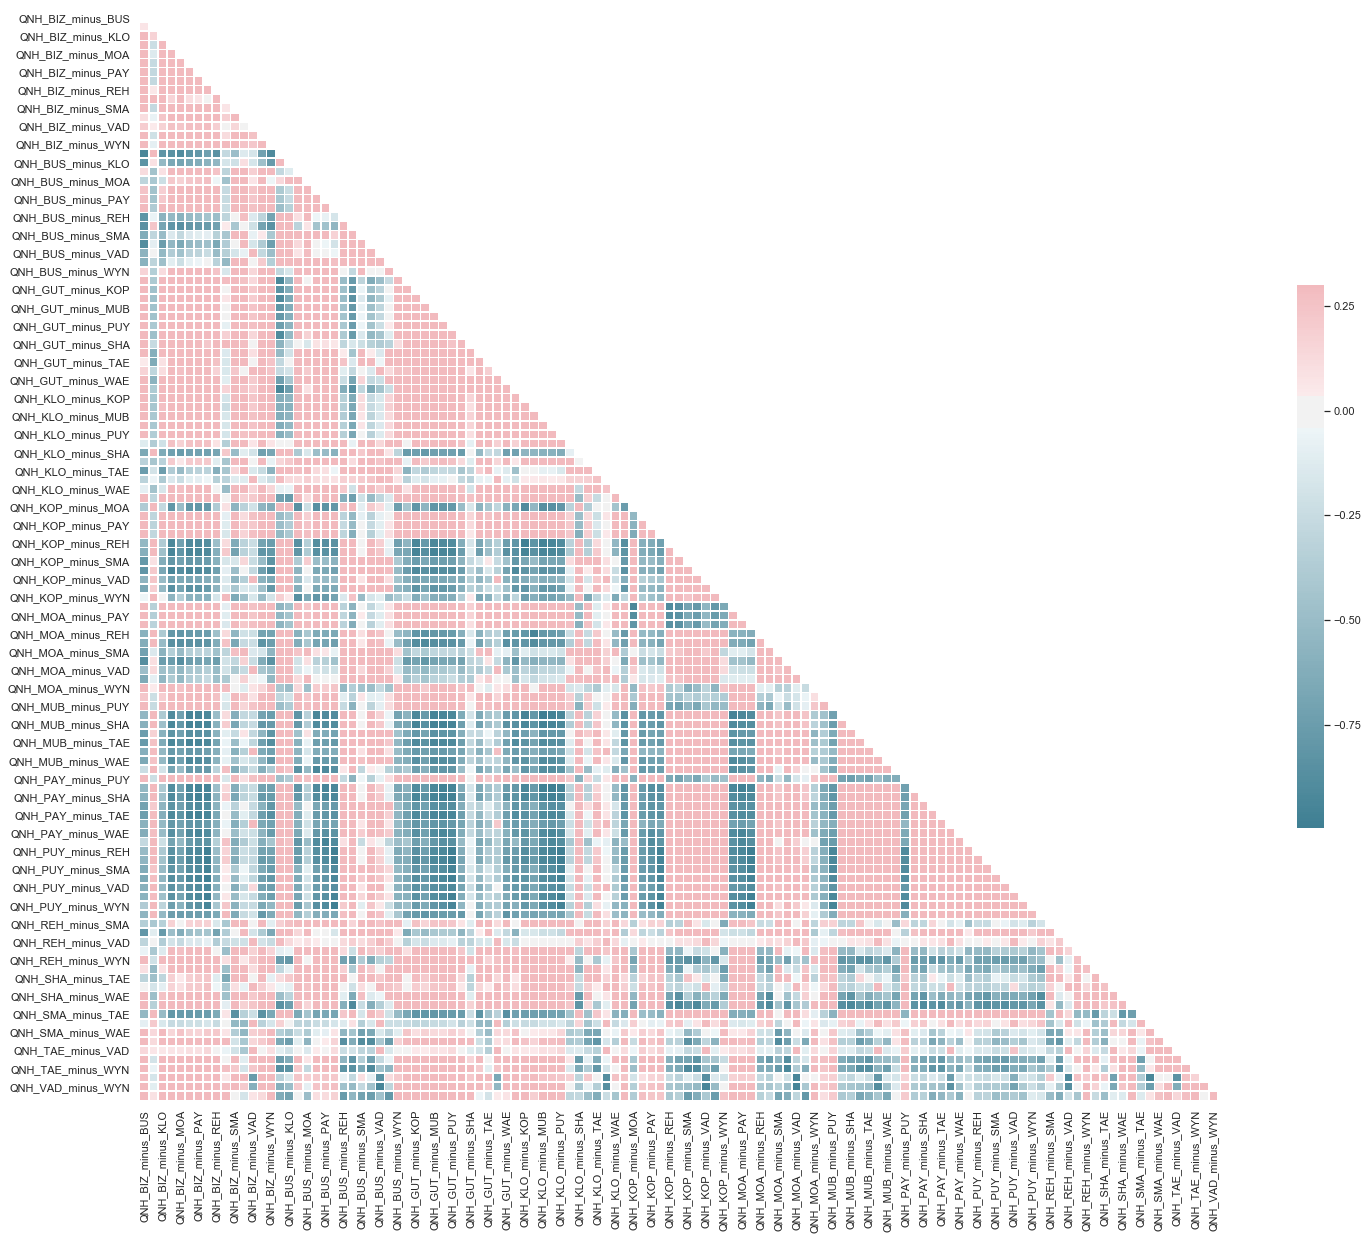

In [6]:
ph.plot_correlation_map(df_minus)

In [12]:
correlated_features = set()
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.8:
            colname = corr.columns[i]
            correlated_features.add(colname)
correlated_features

{'QNH_BIZ_minus_KLO',
 'QNH_BIZ_minus_MOA',
 'QNH_BIZ_minus_MUB',
 'QNH_BIZ_minus_PAY',
 'QNH_BIZ_minus_PUY',
 'QNH_BIZ_minus_REH',
 'QNH_BIZ_minus_TAE',
 'QNH_BIZ_minus_WAE',
 'QNH_BIZ_minus_WYN',
 'QNH_BUS_minus_GUT',
 'QNH_BUS_minus_KLO',
 'QNH_BUS_minus_MUB',
 'QNH_BUS_minus_PAY',
 'QNH_BUS_minus_PUY',
 'QNH_BUS_minus_REH',
 'QNH_BUS_minus_SHA',
 'QNH_BUS_minus_SMA',
 'QNH_BUS_minus_TAE',
 'QNH_BUS_minus_WAE',
 'QNH_BUS_minus_WYN',
 'QNH_GUT_minus_KLO',
 'QNH_GUT_minus_KOP',
 'QNH_GUT_minus_MOA',
 'QNH_GUT_minus_MUB',
 'QNH_GUT_minus_PAY',
 'QNH_GUT_minus_PUY',
 'QNH_GUT_minus_REH',
 'QNH_GUT_minus_SMA',
 'QNH_GUT_minus_TAE',
 'QNH_GUT_minus_VAD',
 'QNH_GUT_minus_WAE',
 'QNH_GUT_minus_WYN',
 'QNH_KLO_minus_KOP',
 'QNH_KLO_minus_MOA',
 'QNH_KLO_minus_MUB',
 'QNH_KLO_minus_PAY',
 'QNH_KLO_minus_PUY',
 'QNH_KLO_minus_SHA',
 'QNH_KLO_minus_SMA',
 'QNH_KLO_minus_TAE',
 'QNH_KLO_minus_VAD',
 'QNH_KLO_minus_WYN',
 'QNH_KOP_minus_MOA',
 'QNH_KOP_minus_PAY',
 'QNH_KOP_minus_PUY',
 'QNH_KOP_

In [15]:
len(correlated_features)

105

In [14]:
feat_subset = ['QNH_PAY_minus_PUY','QNH_PAY_minus_REH','QNH_PAY_minus_SHA','QNH_PAY_minus_SMA',
 'QNH_PAY_minus_TAE','QNH_PAY_minus_VAD','QNH_PAY_minus_WAE','QNH_PAY_minus_WYN',
 'QNH_PUY_minus_REH','QNH_PUY_minus_SHA','QNH_PUY_minus_SMA','QNH_PUY_minus_TAE',
 'QNH_PUY_minus_VAD','QNH_PUY_minus_WAE','QNH_PUY_minus_WYN','QNH_BIZ_minus_KLO',
 'QNH_BIZ_minus_MOA','QNH_BIZ_minus_MUB','QNH_BIZ_minus_PAY','QNH_BIZ_minus_PUY',
 'QNH_BIZ_minus_REH','QNH_BIZ_minus_TAE','QNH_BIZ_minus_WAE','QNH_BIZ_minus_WYN']

corr1 = df_minus = df[feat_subset].corr()
corr1.style.background_gradient(cmap='coolwarm')

In [8]:
l = df_all_features.columns.tolist()
l.sort()
l

['BIZ_Air_temp',
 'BIZ_Hum',
 'BIZ_QFE',
 'BIZ_QFF',
 'BIZ_QNH',
 'BIZ_Wind_dir',
 'BIZ_Wind_max',
 'BIZ_Wind_speed',
 'BUS_Air_temp',
 'BUS_Hum',
 'BUS_QFE',
 'BUS_QFF',
 'BUS_QNH',
 'BUS_Wind_dir',
 'BUS_Wind_max',
 'BUS_Wind_speed',
 'GUT_Air_temp',
 'GUT_Hum',
 'GUT_QFE',
 'GUT_QFF',
 'GUT_QNH',
 'GUT_Wind_dir',
 'GUT_Wind_max',
 'GUT_Wind_speed',
 'KLO_Air_temp',
 'KLO_Hum',
 'KLO_QFE',
 'KLO_QFF',
 'KLO_QNH',
 'KLO_Wind_dir',
 'KLO_Wind_max',
 'KLO_Wind_speed',
 'KOP_Air_temp',
 'KOP_Hum',
 'KOP_QFE',
 'KOP_QFF',
 'KOP_QNH',
 'KOP_Wind_dir',
 'KOP_Wind_max',
 'KOP_Wind_speed',
 'MOA_Air_temp',
 'MOA_Hum',
 'MOA_QFE',
 'MOA_QFF',
 'MOA_QNH',
 'MOA_Wind_dir',
 'MOA_Wind_max',
 'MOA_Wind_speed',
 'MUB_Air_temp',
 'MUB_Hum',
 'MUB_QFE',
 'MUB_QFF',
 'MUB_QNH',
 'MUB_Wind_dir',
 'MUB_Wind_max',
 'MUB_Wind_speed',
 'PAY_Air_temp',
 'PAY_Hum',
 'PAY_QFE',
 'PAY_QFF',
 'PAY_QNH',
 'PAY_Wind_dir',
 'PAY_Wind_max',
 'PAY_Wind_speed',
 'PUY_Air_temp',
 'PUY_Hum',
 'PUY_QFE',
 'PUY_QFF',
 'P

## Highly correlated features tend to split up the importance they have as predictors, and usually call for a reductin in number
### Despite the high correlation shown by these wind related features in the dataset so far, it was strongly requested by management of the project, that model training had to be carried out on the whole feature set, in order to perform a qualitative selection of the features. 

## Add lagged differences

In [7]:
# New features QNH_.... are taken for station features: add QNH to deop stations list
df_all_features = fh.calc_feature_diff_between_stations(df, 'QNH', None, drop_stations=['QNH'], lag=const.steps_10_mins)
print(df_all_features.shape)
df_all_features.head()

KLO
KLO
KLO
KLO
KLO
KLO
KLO
KLO
REH
REH
REH
REH
REH
REH
REH
REH
SMA
SMA
SMA
SMA
SMA
SMA
SMA
SMA
TAE
TAE
TAE
TAE
TAE
TAE
TAE
TAE
WAE
WAE
WAE
WAE
WAE
WAE
WAE
WAE
BIZ
BIZ
BIZ
BIZ
BIZ
BIZ
BIZ
BIZ
BUS
BUS
BUS
BUS
BUS
BUS
BUS
BUS
GUT
GUT
GUT
GUT
GUT
GUT
GUT
GUT
KOP
KOP
KOP
KOP
KOP
KOP
KOP
KOP
MOA
MOA
MOA
MOA
MOA
MOA
MOA
MOA
MUB
MUB
MUB
MUB
MUB
MUB
MUB
MUB
PAY
PAY
PAY
PAY
PAY
PAY
PAY
PAY
PUY
PUY
PUY
PUY
PUY
PUY
PUY
PUY
SHA
SHA
SHA
SHA
SHA
SHA
SHA
SHA
VAD
VAD
VAD
VAD
VAD
VAD
VAD
VAD
WYN
WYN
WYN
WYN
WYN
WYN
WYN
WYN
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
[('BIZ',

datetime  KLO_Wind_dir  KLO_Wind_speed  KLO_Wind_max   KLO_QFF  \
0  2014-01-01 00:00:00       138.000           3.900         5.600 1,019.400   
1  2014-01-01 00:10:00       149.000           3.300         5.700 1,019.500   
2  2014-01-01 00:20:00       145.000           3.100         4.400 1,019.500   
3  2014-01-01 00:30:00       127.000           3.700         4.600 1,019.500   
4  2014-01-01 00:40:00       131.000           4.100         5.000 1,019.300   

    KLO_QNH  KLO_QFE  KLO_Air_temp  KLO_Hum  REH_Wind_dir  REH_Wind_speed  \
0 1,016.600  966.100        -3.000   96.100       104.000           0.900   
1 1,016.700  966.200        -3.000   95.200        93.000           1.300   
2 1,016.700  966.200        -3.000   94.400        69.000           1.300   
3 1,016.700  966.200        -2.900   91.700        79.000           1.400   
4 1,016.600  966.100        -2.800   90.800        98.000           1.200   

   REH_Wind_max   REH_QFF   REH_QNH  REH_QFE  REH_Air_temp  REH_Hum  \
0         1.500 1,019.400 1,016.600  964.100        -2.700   98.100   
1         2.300 1,019.300 1,016.600  964.100        -2.400   98.200   
2         2.000 1,019.400 1,016.600  964.100        -2.600  100.000   
3         2.300 1,019.400 1,016.600  964.100        -2.600   99.000   
4         2.000 1,019.400 1,016.600  964.100        -2.600   98.600   

   SMA_Wind_dir  SMA_Wind_speed  SMA_Wind_max   SMA_QFF   SMA_QNH  SMA_QFE  \
0       201.000           2.400         4.200 1,018.400 1,016.000  950.700   
1       202.000           2.300         5.100 1,018.500 1,016.000  950.700   
2       193.000           3.100         4.600 1,018.400 1,016.000  950.700   
3       200.000           2.600         4.500 1,018.200 1,016.000  950.700   
4       216.000           1.700         4.200 1,018.600 1,016.000  950.700   

   SMA_Air_temp  SMA_Hum  TAE_Wind_dir  TAE_Wind_speed  TAE_Wind_max  \
0         1.000   67.400        68.000           0.800         2.200   
1         0.700   70.600       358.000           1.400         2.600   
2         1.200   65.800       344.000           1.400         2.800   
3         2.000   60.100       229.000           2.500         6.500   
4         0.400   72.200       227.000           3.700         7.900   

    TAE_QFF   TAE_QNH  TAE_QFE  TAE_Air_temp  TAE_Hum  WAE_Wind_dir  \
0 1,019.100 1,015.600  952.300        -3.800   89.500       152.000   
1 1,018.800 1,015.600  952.300        -2.600   84.300       143.000   
2 1,018.200 1,015.600  952.300        -0.200   67.900       127.000   
3 1,017.200 1,015.300  952.100         2.800   56.400       143.000   
4 1,017.000 1,015.200  952.000         3.300   55.400       142.000   

   WAE_Wind_speed  WAE_Wind_max   WAE_QFF   WAE_QNH  WAE_QFE  WAE_Air_temp  \
0           1.900         3.800 1,019.600 1,016.900  959.600        -1.300   
1           2.000         2.900 1,019.500 1,016.900  959.600        -0.800   
2           1.800         3.300 1,019.500 1,017.000  959.700        -0.300   
3           2.400         3.900 1,019.500 1,017.000  959.700        -0.400   
4           2.400         3.900 1,019.400 1,016.900  959.600        -0.200   

   WAE_Hum  BIZ_Wind_dir  BIZ_Wind_speed  BIZ_Wind_max   BIZ_QFF   BIZ_QNH  \
0   82.600       283.000           0.700         1.300 1,020.300 1,016.800   
1   84.300       265.000           0.800         1.500 1,020.200 1,016.700   
2   88.400       238.000           0.700         1.100 1,020.100 1,016.600   
3   88.400       271.000           0.800         1.600 1,020.000 1,016.500   
4   85.900       270.000           0.700         1.200 1,019.800 1,016.400   

   BIZ_QFE  BIZ_Air_temp  BIZ_Hum  BUS_Wind_dir  BUS_Wind_speed  BUS_Wind_max  \
0  961.600        -5.200  100.000       303.000           0.900         1.600   
1  961.500        -5.200  100.000       302.000           1.000         1.700   
2  961.400        -5.300  100.000       261.000           0.500         1.000   
3  961.300        -5.100  100.000       292.000     

In [8]:
df_all_features = fh.calc_feature_diff_between_stations(df_all_features, 'QNH', None, drop_stations=['QNH'], lag=const.steps_20_mins)
print(df_all_features.shape)
df_all_features.head()

KLO
KLO
KLO
KLO
KLO
KLO
KLO
KLO
REH
REH
REH
REH
REH
REH
REH
REH
SMA
SMA
SMA
SMA
SMA
SMA
SMA
SMA
TAE
TAE
TAE
TAE
TAE
TAE
TAE
TAE
WAE
WAE
WAE
WAE
WAE
WAE
WAE
WAE
BIZ
BIZ
BIZ
BIZ
BIZ
BIZ
BIZ
BIZ
BUS
BUS
BUS
BUS
BUS
BUS
BUS
BUS
GUT
GUT
GUT
GUT
GUT
GUT
GUT
GUT
KOP
KOP
KOP
KOP
KOP
KOP
KOP
KOP
MOA
MOA
MOA
MOA
MOA
MOA
MOA
MOA
MUB
MUB
MUB
MUB
MUB
MUB
MUB
MUB
PAY
PAY
PAY
PAY
PAY
PAY
PAY
PAY
PUY
PUY
PUY
PUY
PUY
PUY
PUY
PUY
SHA
SHA
SHA
SHA
SHA
SHA
SHA
SHA
VAD
VAD
VAD
VAD
VAD
VAD
VAD
VAD
WYN
WYN
WYN
WYN
WYN
WYN
WYN
WYN
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH
QNH


datetime  KLO_Wind_dir  KLO_Wind_speed  KLO_Wind_max   KLO_QFF  \
0  2014-01-01 00:00:00       138.000           3.900         5.600 1,019.400   
1  2014-01-01 00:10:00       149.000           3.300         5.700 1,019.500   
2  2014-01-01 00:20:00       145.000           3.100         4.400 1,019.500   
3  2014-01-01 00:30:00       127.000           3.700         4.600 1,019.500   
4  2014-01-01 00:40:00       131.000           4.100         5.000 1,019.300   

    KLO_QNH  KLO_QFE  KLO_Air_temp  KLO_Hum  REH_Wind_dir  REH_Wind_speed  \
0 1,016.600  966.100        -3.000   96.100       104.000           0.900   
1 1,016.700  966.200        -3.000   95.200        93.000           1.300   
2 1,016.700  966.200        -3.000   94.400        69.000           1.300   
3 1,016.700  966.200        -2.900   91.700        79.000           1.400   
4 1,016.600  966.100        -2.800   90.800        98.000           1.200   

   REH_Wind_max   REH_QFF   REH_QNH  REH_QFE  REH_Air_temp  REH_Hum  \
0         1.500 1,019.400 1,016.600  964.100        -2.700   98.100   
1         2.300 1,019.300 1,016.600  964.100        -2.400   98.200   
2         2.000 1,019.400 1,016.600  964.100        -2.600  100.000   
3         2.300 1,019.400 1,016.600  964.100        -2.600   99.000   
4         2.000 1,019.400 1,016.600  964.100        -2.600   98.600   

   SMA_Wind_dir  SMA_Wind_speed  SMA_Wind_max   SMA_QFF   SMA_QNH  SMA_QFE  \
0       201.000           2.400         4.200 1,018.400 1,016.000  950.700   
1       202.000           2.300         5.100 1,018.500 1,016.000  950.700   
2       193.000           3.100         4.600 1,018.400 1,016.000  950.700   
3       200.000           2.600         4.500 1,018.200 1,016.000  950.700   
4       216.000           1.700         4.200 1,018.600 1,016.000  950.700   

   SMA_Air_temp  SMA_Hum  TAE_Wind_dir  TAE_Wind_speed  TAE_Wind_max  \
0         1.000   67.400        68.000           0.800         2.200   
1         0.700   70.600       358.000           1.400         2.600   
2         1.200   65.800       344.000           1.400         2.800   
3         2.000   60.100       229.000           2.500         6.500   
4         0.400   72.200       227.000           3.700         7.900   

    TAE_QFF   TAE_QNH  TAE_QFE  TAE_Air_temp  TAE_Hum  WAE_Wind_dir  \
0 1,019.100 1,015.600  952.300        -3.800   89.500       152.000   
1 1,018.800 1,015.600  952.300        -2.600   84.300       143.000   
2 1,018.200 1,015.600  952.300        -0.200   67.900       127.000   
3 1,017.200 1,015.300  952.100         2.800   56.400       143.000   
4 1,017.000 1,015.200  952.000         3.300   55.400       142.000   

   WAE_Wind_speed  WAE_Wind_max   WAE_QFF   WAE_QNH  WAE_QFE  WAE_Air_temp  \
0           1.900         3.800 1,019.600 1,016.900  959.600        -1.300   
1           2.000         2.900 1,019.500 1,016.900  959.600        -0.800   
2           1.800         3.300 1,019.500 1,017.000  959.700        -0.300   
3           2.400         3.900 1,019.500 1,017.000  959.700        -0.400   
4           2.400         3.900 1,019.400 1,016.900  959.600        -0.200   

   WAE_Hum  BIZ_Wind_dir  BIZ_Wind_speed  BIZ_Wind_max   BIZ_QFF   BIZ_QNH  \
0   82.600       283.000           0.700         1.300 1,020.300 1,016.800   
1   84.300       265.000           0.800         1.500 1,020.200 1,016.700   
2   88.400       238.000           0.700         1.100 1,020.100 1,016.600   
3   88.400       271.000           0.800         1.600 1,020.000 1,016.500   
4   85.900       270.000           0.700         1.200 1,019.800 1,016.400   

   BIZ_QFE  BIZ_Air_temp  BIZ_Hum  BUS_Wind_dir  BUS_Wind_speed  BUS_Wind_max  \
0  961.600        -5.200  100.000       303.000           0.900         1.600   
1  961.500        -5.200  100.000       302.000           1.000         1.700   
2  961.400        -5.300  100.000       261.000           0.500         1.000   
3  961.300        -5.100  100.000       292.000     

In [9]:
df_all_features.shape

(262801, 489)

In [10]:
dh.store_df_as_csv_compressed(df_all_features, 'model_data_QNH_features.csv.zip')

### Import the new dataset and remove unused pressure features

In [4]:
df_master = dh.load_df_from_csv('model_data_all_features_extended.csv.zip')

In [6]:
df_master.head()

datetime  KLO_Air_temp  KLO_Hum  KLO_Hum_delta_3  \
0  2014-01-01 00:00:00        -3.000   96.100              nan   
1  2014-01-01 00:10:00        -3.000   95.200              nan   
2  2014-01-01 00:20:00        -3.000   94.400              nan   
3  2014-01-01 00:30:00        -2.900   91.700           -4.400   
4  2014-01-01 00:40:00        -2.800   90.800           -4.400   

   KLO_Hum_delta_6  KLO_QFE   KLO_QFF   KLO_QNH  KLO_Wind_dir  \
0              nan  966.100 1,019.400 1,016.600       138.000   
1              nan  966.200 1,019.500 1,016.700       149.000   
2              nan  966.200 1,019.500 1,016.700       145.000   
3              nan  966.200 1,019.500 1,016.700       127.000   
4              nan  966.100 1,019.300 1,016.600       131.000   

   KLO_Wind_dir_delta  KLO_Wind_dir_delta-3  KLO_Wind_dir_delta-6  \
0                 nan                   nan                   nan   
1              11.000                   nan                   nan   
2              -4.000                   nan                   nan   
3             -18.000               -11.000                   nan   
4               4.000               -18.000                   nan   

   KLO_Wind_max  KLO_Wind_max_delta_3  KLO_Wind_max_delta_6  KLO_Wind_speed  \
0         5.600                   nan                   nan           3.900   
1         5.700                   nan                   nan           3.300   
2         4.400                   nan                   nan           3.100   
3         4.600                -1.000                   nan           3.700   
4         5.000                -0.700                   nan           4.100   

   KLO_Wind_speed_delta_3  KLO_Wind_speed_delta_6  BIZ_Air_temp  BIZ_Hum  \
0                     nan                     nan        -5.200  100.000   
1                     nan                     nan        -5.200  100.000   
2                     nan                     nan        -5.300  100.000   
3                  -0.200                     nan        -5.100  100.000   
4                   0.800                     nan        -4.600  100.000   

   BIZ_Hum_delta_3  BIZ_Hum_delta_6  BIZ_QFE   BIZ_QFF   BIZ_QNH  \
0              nan              nan  961.600 1,020.300 1,016.800   
1              nan              nan  961.500 1,020.200 1,016.700   
2              nan              nan  961.400 1,020.100 1,016.600   
3            0.000              nan  961.300 1,020.000 1,016.500   
4            0.000              nan  961.200 1,019.800 1,016.400   

   BIZ_Wind_dir  BIZ_Wind_dir_delta  BIZ_Wind_dir_delta-3  \
0       283.000                 nan                   nan   
1       265.000             -18.000                   nan   
2       238.000             -27.000                   nan   
3       271.000              33.000               -12.000   
4       270.000              -1.000                 5.000   

   BIZ_Wind_dir_delta-6  BIZ_Wind_max  BIZ_Wind_max_delta_3  \
0                   nan         1.300                   nan   
1                   nan         1.500                   nan   
2                   nan         1.100                   nan   
3                   nan         1.600                 0.300   
4                   nan         1.200                -0.300   

   BIZ_Wind_max_delta_6  BIZ_Wind_speed  BIZ_Wind_speed_delta_3  \
0                   nan           0.700                     nan   
1                   nan           0.800                     nan   
2                   nan           0.700                     nan   
3                   nan           0.800                   0.100   
4                   nan           0.700                  -0.100   

   BIZ_Wind_speed_delta_6  BUS_Air_temp  BUS_Hum  BUS_Hum_delta_3  \
0                     nan        -1.100   94.100              nan   
1                     nan        -1.000   93.900              nan   
2                     nan        -0.800   92.600              nan   
3                     nan        -0.700   93.

In [10]:
cols_drop = [c for c in df_master.columns if re.search('(?:QFF|QFE)', c)]
df_master.drop(columns=cols_drop, inplace=True)

In [11]:
df_master.shape

(262801, 481)

In [13]:
dh.store_df_as_csv_compressed(df_master, 'model_data_all_features_extended.csv.zip')

In [25]:
feats_for_delta = [c for c in df_master.columns if re.search('^QNH_.*(?<!delta)$', c)]
feats_for_delta

['QNH_BIZ_minus_KLO',
 'QNH_BUS_minus_KLO',
 'QNH_GUT_minus_KLO',
 'QNH_KLO_minus_KOP',
 'QNH_KLO_minus_MOA',
 'QNH_KLO_minus_MUB',
 'QNH_KLO_minus_PAY',
 'QNH_KLO_minus_PUY',
 'QNH_KLO_minus_REH',
 'QNH_KLO_minus_SHA',
 'QNH_KLO_minus_SMA',
 'QNH_KLO_minus_TAE',
 'QNH_KLO_minus_VAD',
 'QNH_KLO_minus_WAE',
 'QNH_KLO_minus_WYN',
 'QNH_BIZ_minus_BUS',
 'QNH_BIZ_minus_GUT',
 'QNH_BIZ_minus_KOP',
 'QNH_BIZ_minus_MOA',
 'QNH_BIZ_minus_MUB',
 'QNH_BIZ_minus_PAY',
 'QNH_BIZ_minus_PUY',
 'QNH_BIZ_minus_REH',
 'QNH_BIZ_minus_SHA',
 'QNH_BIZ_minus_SMA',
 'QNH_BIZ_minus_TAE',
 'QNH_BIZ_minus_VAD',
 'QNH_BIZ_minus_WAE',
 'QNH_BIZ_minus_WYN',
 'QNH_BUS_minus_GUT',
 'QNH_BUS_minus_KOP',
 'QNH_BUS_minus_MOA',
 'QNH_BUS_minus_MUB',
 'QNH_BUS_minus_PAY',
 'QNH_BUS_minus_PUY',
 'QNH_BUS_minus_REH',
 'QNH_BUS_minus_SHA',
 'QNH_BUS_minus_SMA',
 'QNH_BUS_minus_TAE',
 'QNH_BUS_minus_VAD',
 'QNH_BUS_minus_WAE',
 'QNH_BUS_minus_WYN',
 'QNH_GUT_minus_KOP',
 'QNH_GUT_minus_MOA',
 'QNH_GUT_minus_MUB',
 'QNH_GUT_

In [52]:
def insert_delta_cols(df, feats_for_delta, lag=1, shift=1):
    print(len(df.columns))
    for orig_name in feats_for_delta:
        new_name = orig_name + '_delta'
        if lag > 1:
            new_name += '_' + str(lag)
        
        col_index = df.columns.get_loc(orig_name) + shift
        cols_untouched = df.columns.tolist()[:col_index]
        #print(cols_untouched)
        cols_shifted = df.columns.tolist()[col_index:]
        print(new_name, col_index, len(cols_untouched), len(cols_shifted))
        df[new_name] = df[orig_name].diff(periods=lag)
        #print(cols_shifted)
        sorted_cols = cols_untouched + [new_name] + cols_shifted    
        df = df.reindex(columns=sorted_cols)
        print(len(df.columns))
    return df

In [35]:
df = df_master.copy()
df = insert_delta_cols(df, feats_for_delta, const.steps_20_mins)

481
QNH_BIZ_minus_KLO_delta_2
482
QNH_BUS_minus_KLO_delta_2
483
QNH_GUT_minus_KLO_delta_2
484
QNH_KLO_minus_KOP_delta_2
485
QNH_KLO_minus_MOA_delta_2
486
QNH_KLO_minus_MUB_delta_2
487
QNH_KLO_minus_PAY_delta_2
488
QNH_KLO_minus_PUY_delta_2
489
QNH_KLO_minus_REH_delta_2
490
QNH_KLO_minus_SHA_delta_2
491
QNH_KLO_minus_SMA_delta_2
492
QNH_KLO_minus_TAE_delta_2
493
QNH_KLO_minus_VAD_delta_2
494
QNH_KLO_minus_WAE_delta_2
495
QNH_KLO_minus_WYN_delta_2
496
QNH_BIZ_minus_BUS_delta_2
497
QNH_BIZ_minus_GUT_delta_2
498
QNH_BIZ_minus_KOP_delta_2
499
QNH_BIZ_minus_MOA_delta_2
500
QNH_BIZ_minus_MUB_delta_2
501
QNH_BIZ_minus_PAY_delta_2
502
QNH_BIZ_minus_PUY_delta_2
503
QNH_BIZ_minus_REH_delta_2
504
QNH_BIZ_minus_SHA_delta_2
505
QNH_BIZ_minus_SMA_delta_2
506
QNH_BIZ_minus_TAE_delta_2
507
QNH_BIZ_minus_VAD_delta_2
508
QNH_BIZ_minus_WAE_delta_2
509
QNH_BIZ_minus_WYN_delta_2
510
QNH_BUS_minus_GUT_delta_2
511
QNH_BUS_minus_KOP_delta_2
512
QNH_BUS_minus_MOA_delta_2
513
QNH_BUS_minus_MUB_delta_2
514
QNH_BU

In [45]:
df.columns.tolist()

['datetime',
 'KLO_Air_temp',
 'KLO_Hum',
 'KLO_Hum_delta_3',
 'KLO_Hum_delta_6',
 'KLO_QNH',
 'KLO_Wind_dir',
 'KLO_Wind_dir_delta',
 'KLO_Wind_dir_delta-3',
 'KLO_Wind_dir_delta-6',
 'KLO_Wind_max',
 'KLO_Wind_max_delta_3',
 'KLO_Wind_max_delta_6',
 'KLO_Wind_speed',
 'KLO_Wind_speed_delta_3',
 'KLO_Wind_speed_delta_6',
 'BIZ_Air_temp',
 'BIZ_Hum',
 'BIZ_Hum_delta_3',
 'BIZ_Hum_delta_6',
 'BIZ_QNH',
 'BIZ_Wind_dir',
 'BIZ_Wind_dir_delta',
 'BIZ_Wind_dir_delta-3',
 'BIZ_Wind_dir_delta-6',
 'BIZ_Wind_max',
 'BIZ_Wind_max_delta_3',
 'BIZ_Wind_max_delta_6',
 'BIZ_Wind_speed',
 'BIZ_Wind_speed_delta_3',
 'BIZ_Wind_speed_delta_6',
 'BUS_Air_temp',
 'BUS_Hum',
 'BUS_Hum_delta_3',
 'BUS_Hum_delta_6',
 'BUS_QNH',
 'BUS_Wind_dir',
 'BUS_Wind_dir_delta',
 'BUS_Wind_dir_delta-3',
 'BUS_Wind_dir_delta-6',
 'BUS_Wind_max',
 'BUS_Wind_max_delta_3',
 'BUS_Wind_max_delta_6',
 'BUS_Wind_speed',
 'BUS_Wind_speed_delta_3',
 'BUS_Wind_speed_delta_6',
 'GUT_Air_temp',
 'GUT_Hum',
 'GUT_Hum_delta_3',
 'GUT

In [42]:
print(df_master.shape, df.shape)

(262801, 481) (262801, 721)


In [50]:
cols_del = [c for c in df.columns if re.search('^QNH_.*6$', c)]
cols_del

['QNH_BIZ_minus_KLO_delta_6',
 'QNH_BUS_minus_KLO_delta_6',
 'QNH_GUT_minus_KLO_delta_6',
 'QNH_KLO_minus_KOP_delta_6',
 'QNH_KLO_minus_MOA_delta_6',
 'QNH_KLO_minus_MUB_delta_6',
 'QNH_KLO_minus_PAY_delta_6',
 'QNH_KLO_minus_PUY_delta_6',
 'QNH_KLO_minus_REH_delta_6',
 'QNH_KLO_minus_SHA_delta_6',
 'QNH_KLO_minus_SMA_delta_6',
 'QNH_KLO_minus_TAE_delta_6',
 'QNH_KLO_minus_VAD_delta_6',
 'QNH_KLO_minus_WAE_delta_6',
 'QNH_KLO_minus_WYN_delta_6',
 'QNH_BIZ_minus_BUS_delta_6',
 'QNH_BIZ_minus_GUT_delta_6',
 'QNH_BIZ_minus_KOP_delta_6',
 'QNH_BIZ_minus_MOA_delta_6',
 'QNH_BIZ_minus_MUB_delta_6',
 'QNH_BIZ_minus_PAY_delta_6',
 'QNH_BIZ_minus_PUY_delta_6',
 'QNH_BIZ_minus_REH_delta_6',
 'QNH_BIZ_minus_SHA_delta_6',
 'QNH_BIZ_minus_SMA_delta_6',
 'QNH_BIZ_minus_TAE_delta_6',
 'QNH_BIZ_minus_VAD_delta_6',
 'QNH_BIZ_minus_WAE_delta_6',
 'QNH_BIZ_minus_WYN_delta_6',
 'QNH_BUS_minus_GUT_delta_6',
 'QNH_BUS_minus_KOP_delta_6',
 'QNH_BUS_minus_MOA_delta_6',
 'QNH_BUS_minus_MUB_delta_6',
 'QNH_BUS_

In [51]:
df.drop(columns=cols_del, inplace=True)
dh.store_df_as_csv_compressed(df, 'model_data_all_features_extended.csv.zip')

In [48]:
df.head()

datetime  KLO_Air_temp  KLO_Hum  KLO_Hum_delta_3  \
0  2014-01-01 00:00:00        -3.000   96.100              nan   
1  2014-01-01 00:10:00        -3.000   95.200              nan   
2  2014-01-01 00:20:00        -3.000   94.400              nan   
3  2014-01-01 00:30:00        -2.900   91.700           -4.400   
4  2014-01-01 00:40:00        -2.800   90.800           -4.400   

   KLO_Hum_delta_6   KLO_QNH  KLO_Wind_dir  KLO_Wind_dir_delta  \
0              nan 1,016.600       138.000                 nan   
1              nan 1,016.700       149.000              11.000   
2              nan 1,016.700       145.000              -4.000   
3              nan 1,016.700       127.000             -18.000   
4              nan 1,016.600       131.000               4.000   

   KLO_Wind_dir_delta-3  KLO_Wind_dir_delta-6  KLO_Wind_max  \
0                   nan                   nan         5.600   
1                   nan                   nan         5.700   
2                   nan                   nan         4.400   
3               -11.000                   nan         4.600   
4               -18.000                   nan         5.000   

   KLO_Wind_max_delta_3  KLO_Wind_max_delta_6  KLO_Wind_speed  \
0                   nan                   nan           3.900   
1                   nan                   nan           3.300   
2                   nan                   nan           3.100   
3                -1.000                   nan           3.700   
4                -0.700                   nan           4.100   

   KLO_Wind_speed_delta_3  KLO_Wind_speed_delta_6  BIZ_Air_temp  BIZ_Hum  \
0                     nan                     nan        -5.200  100.000   
1                     nan                     nan        -5.200  100.000   
2                     nan                     nan        -5.300  100.000   
3                  -0.200                     nan        -5.100  100.000   
4                   0.800                     nan        -4.600  100.000   

   BIZ_Hum_delta_3  BIZ_Hum_delta_6   BIZ_QNH  BIZ_Wind_dir  \
0              nan              nan 1,016.800       283.000   
1              nan              nan 1,016.700       265.000   
2              nan              nan 1,016.600       238.000   
3            0.000              nan 1,016.500       271.000   
4            0.000              nan 1,016.400       270.000   

   BIZ_Wind_dir_delta  BIZ_Wind_dir_delta-3  BIZ_Wind_dir_delta-6  \
0                 nan                   nan                   nan   
1             -18.000                   nan                   nan   
2             -27.000                   nan                   nan   
3              33.000               -12.000                   nan   
4              -1.000                 5.000                   nan   

   BIZ_Wind_max  BIZ_Wind_max_delta_3  BIZ_Wind_max_delta_6  BIZ_Wind_speed  \
0         1.300                   nan                   nan           0.700   
1         1.500                   nan                   nan           0.800   
2         1.100                   nan                   nan           0.700   
3         1.600                 0.300                   nan           0.800   
4         1.200                -0.300                   nan           0.700   

   BIZ_Wind_speed_delta_3  BIZ_Wind_speed_delta_6  BUS_Air_temp  BUS_Hum  \
0                     nan                     nan        -1.100   94.100   
1                     nan                     nan        -1.000   93.900   
2                     nan                     nan        -0.800   92.600   
3                   0.100                     nan        -0.700   93.400   
4                  -0.100                     nan        -0.900   94.800   

   BUS_Hum_delta_3  BUS_Hum_delta_6   BUS_QNH  BUS_Wind_dir  \
0              nan              nan 1,017.100       303.000   
1              nan              nan 1,017.000       302.000   
2              nan              nan 1,016.900       261.000   
3           -0.

In [53]:
df = insert_delta_cols(df, feats_for_delta, const.steps_1_hour, 3)

601
QNH_BIZ_minus_KLO_delta_6 244 244 357
602
QNH_BUS_minus_KLO_delta_6 248 248 354
603
QNH_GUT_minus_KLO_delta_6 252 252 351
604
QNH_KLO_minus_KOP_delta_6 256 256 348
605
QNH_KLO_minus_MOA_delta_6 260 260 345
606
QNH_KLO_minus_MUB_delta_6 264 264 342
607
QNH_KLO_minus_PAY_delta_6 268 268 339
608
QNH_KLO_minus_PUY_delta_6 272 272 336
609
QNH_KLO_minus_REH_delta_6 276 276 333
610
QNH_KLO_minus_SHA_delta_6 280 280 330
611
QNH_KLO_minus_SMA_delta_6 284 284 327
612
QNH_KLO_minus_TAE_delta_6 288 288 324
613
QNH_KLO_minus_VAD_delta_6 292 292 321
614
QNH_KLO_minus_WAE_delta_6 296 296 318
615
QNH_KLO_minus_WYN_delta_6 300 300 315
616
QNH_BIZ_minus_BUS_delta_6 304 304 312
617
QNH_BIZ_minus_GUT_delta_6 308 308 309
618
QNH_BIZ_minus_KOP_delta_6 312 312 306
619
QNH_BIZ_minus_MOA_delta_6 316 316 303
620
QNH_BIZ_minus_MUB_delta_6 320 320 300
621
QNH_BIZ_minus_PAY_delta_6 324 324 297
622
QNH_BIZ_minus_PUY_delta_6 328 328 294
623
QNH_BIZ_minus_REH_delta_6 332 332 291
624
QNH_BIZ_minus_SHA_delta_6 336 

In [54]:
df.head()

datetime  KLO_Air_temp  KLO_Hum  KLO_Hum_delta_3  \
0  2014-01-01 00:00:00        -3.000   96.100              nan   
1  2014-01-01 00:10:00        -3.000   95.200              nan   
2  2014-01-01 00:20:00        -3.000   94.400              nan   
3  2014-01-01 00:30:00        -2.900   91.700           -4.400   
4  2014-01-01 00:40:00        -2.800   90.800           -4.400   

   KLO_Hum_delta_6   KLO_QNH  KLO_Wind_dir  KLO_Wind_dir_delta  \
0              nan 1,016.600       138.000                 nan   
1              nan 1,016.700       149.000              11.000   
2              nan 1,016.700       145.000              -4.000   
3              nan 1,016.700       127.000             -18.000   
4              nan 1,016.600       131.000               4.000   

   KLO_Wind_dir_delta-3  KLO_Wind_dir_delta-6  KLO_Wind_max  \
0                   nan                   nan         5.600   
1                   nan                   nan         5.700   
2                   nan                   nan         4.400   
3               -11.000                   nan         4.600   
4               -18.000                   nan         5.000   

   KLO_Wind_max_delta_3  KLO_Wind_max_delta_6  KLO_Wind_speed  \
0                   nan                   nan           3.900   
1                   nan                   nan           3.300   
2                   nan                   nan           3.100   
3                -1.000                   nan           3.700   
4                -0.700                   nan           4.100   

   KLO_Wind_speed_delta_3  KLO_Wind_speed_delta_6  BIZ_Air_temp  BIZ_Hum  \
0                     nan                     nan        -5.200  100.000   
1                     nan                     nan        -5.200  100.000   
2                     nan                     nan        -5.300  100.000   
3                  -0.200                     nan        -5.100  100.000   
4                   0.800                     nan        -4.600  100.000   

   BIZ_Hum_delta_3  BIZ_Hum_delta_6   BIZ_QNH  BIZ_Wind_dir  \
0              nan              nan 1,016.800       283.000   
1              nan              nan 1,016.700       265.000   
2              nan              nan 1,016.600       238.000   
3            0.000              nan 1,016.500       271.000   
4            0.000              nan 1,016.400       270.000   

   BIZ_Wind_dir_delta  BIZ_Wind_dir_delta-3  BIZ_Wind_dir_delta-6  \
0                 nan                   nan                   nan   
1             -18.000                   nan                   nan   
2             -27.000                   nan                   nan   
3              33.000               -12.000                   nan   
4              -1.000                 5.000                   nan   

   BIZ_Wind_max  BIZ_Wind_max_delta_3  BIZ_Wind_max_delta_6  BIZ_Wind_speed  \
0         1.300                   nan                   nan           0.700   
1         1.500                   nan                   nan           0.800   
2         1.100                   nan                   nan           0.700   
3         1.600                 0.300                   nan           0.800   
4         1.200                -0.300                   nan           0.700   

   BIZ_Wind_speed_delta_3  BIZ_Wind_speed_delta_6  BUS_Air_temp  BUS_Hum  \
0                     nan                     nan        -1.100   94.100   
1                     nan                     nan        -1.000   93.900   
2                     nan                     nan        -0.800   92.600   
3                   0.100                     nan        -0.700   93.400   
4                  -0.100                     nan        -0.900   94.800   

   BUS_Hum_delta_3  BUS_Hum_delta_6   BUS_QNH  BUS_Wind_dir  \
0              nan              nan 1,017.100       303.000   
1              nan              nan 1,017.000       302.000   
2              nan              nan 1,016.900       261.000   
3           -0.

In [55]:
dh.store_df_as_csv_compressed(df, 'model_data_all_features_extended.csv.zip')

In [56]:
df.shape

(262801, 721)

In [57]:
df_master = df.copy()